By: MW Kamdar

Some data analysis on the IPL cricket tournament, using the dataset found at https://www.kaggle.com/ramjidoolla/ipl-data-set

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

A quick peek at the "matches" dataset, after some basic data preperation: 

In [2]:
df_matches = pd.read_csv('ipl\matches.csv')
df_matches.set_index('id',inplace=True,drop=False)
df_matches.drop(columns=['umpire1','umpire2','umpire3'], inplace=True)
df_matches.rename(columns={'Season':'season'}, inplace=True)
df_matches.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)
df_matches.replace('Delhi Daredevils','Delhi Capitals',inplace=True)
df_matches.rename_axis(None, axis='rows',inplace=True)
df_matches.rename_axis("id", axis='columns',inplace=True)
df_matches.head()

id,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
1,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal"
2,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,field,normal,0,Rising Pune Supergiants,0,7,SPD Smith,Maharashtra Cricket Association Stadium
3,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium
4,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiants,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium
5,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium


I would first like to examine the evolution of the structure of the IPL, by examining the number of matches played, the number of teams competing, and the duration of the tournament per season. We can then examine how "tightly packed" the schedule is by calculating the average number of matches played per day.

In [3]:
s_match = df_matches.groupby('season').agg(num_matches=('id','count'))
s_match.T

season,IPL-2008,IPL-2009,IPL-2010,IPL-2011,IPL-2012,IPL-2013,IPL-2014,IPL-2015,IPL-2016,IPL-2017,IPL-2018,IPL-2019
num_matches,58,57,60,73,74,76,60,59,60,59,60,60


In [4]:
s_team = df_matches.groupby('season').agg(num_teams=('team1','nunique'))
s_team.T

season,IPL-2008,IPL-2009,IPL-2010,IPL-2011,IPL-2012,IPL-2013,IPL-2014,IPL-2015,IPL-2016,IPL-2017,IPL-2018,IPL-2019
num_teams,8,8,8,10,9,9,8,8,8,8,8,8


In [5]:
df_matches['date']=pd.to_datetime(df_matches['date'], format="%d-%m-%Y")
df_matches['date'].dtype
seasons = df_matches.groupby('season')['date']
s_diff = (seasons.max()-seasons.min()).to_frame()
s_diff.rename(columns={'date':'num_days'},inplace=True)
s_diff['num_days']=s_diff['num_days'].dt.days
s_diff.T

season,IPL-2008,IPL-2009,IPL-2010,IPL-2011,IPL-2012,IPL-2013,IPL-2014,IPL-2015,IPL-2016,IPL-2017,IPL-2018,IPL-2019
num_days,44,36,44,50,53,53,46,46,50,46,50,50


In [6]:
pd.options.display.float_format = '{:.2f}'.format
s_days_match = (s_diff['num_days']/s_match['num_matches'])
s_days_match = s_days_match.to_frame()
s_days_match.rename(index={0:'days/match'},inplace=True)
s_days_match.rename(columns={0:'days/match'},inplace=True)
s_days_match.T

season,IPL-2008,IPL-2009,IPL-2010,IPL-2011,IPL-2012,IPL-2013,IPL-2014,IPL-2015,IPL-2016,IPL-2017,IPL-2018,IPL-2019
days/match,0.76,0.63,0.73,0.68,0.72,0.70,0.77,0.78,0.83,0.78,0.83,0.83


Lets combine our findings into a new dataset, and graph our findings to more easily gain some insights

In [7]:
from functools import reduce
s_combined = reduce(lambda left,right: pd.merge(left,right,on=['season'],
                                            how='outer'), [s_match,s_team*10,s_diff,s_days_match*40])
s_combined.reset_index(inplace=True)
s_combined.rename(columns={'num_matches':'# of matches','num_teams':'# of teams(x10)','num_days':'# of days','days/match':'days per match(x40)'},inplace=True)
s_comb_melt = pd.melt(s_combined, id_vars="season", var_name="legend", value_name="value")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

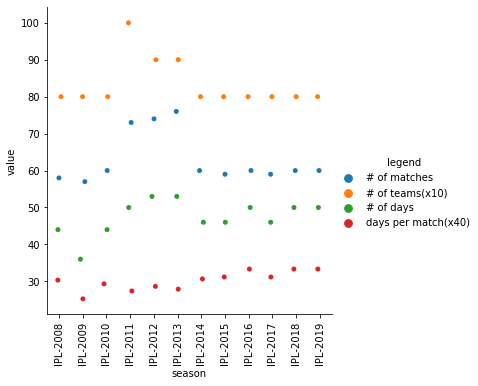

In [8]:
sns.catplot(x='season',y='value',hue='legend',data=s_comb_melt)
plt.xticks(rotation=90)

Some arbitrary scaling has been applied to more easily visualise patterns. Looking closely, certain interesting details are apparent:

We notice the schedule for 2009 was particularly packed. This can be attributed to the fact that this edition was the year the IPL was held in South Africa, due to the tournament conflicting with the Indian elections. The duration of the tournament was cut short by increasing the tightness of the scheduling to accomodate this fact.

In 2011 up until 2013, the IPL attempted to expand the competition by increasing the number of teams participating, resulting in an increase in the duration of the tournament, and the number of matches played. However, it appears more is not always better, and from 2014 onwards they have settled back to only 8 franchises participating.

It can only be seen that from 2014 onwards, the scheduling has been more relaxed than in prior years, perhaps to give players a longer rest between matches, improving the quality of the competition. Another possibility is that the tighter schedules resulted in multiple "double headers" where two matches are played on the same day, which likely resulted in lower viewership numbers and perhaps even viewer "burnout".

Let us next examine which are the most successful franchises in IPL history

In [9]:
finals = df_matches.groupby('season').max()['id']
winners = df_matches[df_matches['id'].isin(finals)][['id','season','winner']].sort_values('season')
trophies = winners['winner'].value_counts()

tot_matches = (df_matches.groupby('team1').count() + df_matches.groupby('team2').count()).sort_values('id',ascending=False)['id']
tot_wins = df_matches.groupby('winner').count()['id'].sort_values(ascending=False)  #
win_p = (100*tot_wins/tot_matches).sort_values(ascending=False)

In [10]:
#Partially based on https://sportsfancovers.com/ipl-color-codes/
colour_teams = {'Chennai Super Kings':'#fcce06','Delhi Capitals':'#2561ae','Kings XI Punjab':'#fa1934','Kolkata Knight Riders':'#3a225d',
                'Mumbai Indians':'#004f91','Royal Challengers Bangalore':'#b80d21','Rajasthan Royals':'#e75480','Sunrisers Hyderabad':'#ff4500',
                'Deccan Chargers':'#c0c0c0','Rising Pune Supergiants':'#c94d95','Kochi Tuskers Kerala':'#fdad5c','Pune Warriors':'#40e0d0',
                'Gujarat Lions':'#ff8c00'}

Text(0.5, 1.0, 'Franchise match win percentage')

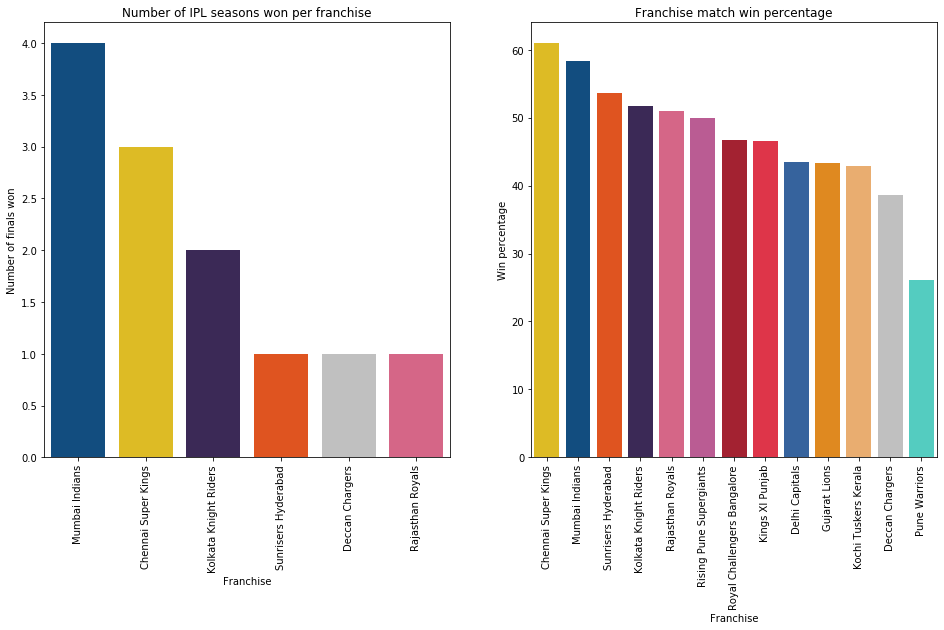

In [11]:
tlist = list(trophies.index)
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
sns.barplot(trophies.index,trophies.values,ax=ax[0],palette=colour_teams)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Franchise')
ax[0].set_ylabel('Number of finals won')
ax[0].set_title("Number of IPL seasons won per franchise")
sns.barplot(win_p.index,win_p.values,ax=ax[1],palette=colour_teams)
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Franchise')
ax[1].set_ylabel('Win percentage')
ax[1].set_title("Franchise match win percentage")

Mumbai Indians (MI) are the most successful franchise with 4 IPL trophies, closely followed by Chennai Super Kings (CSK) and Kolkata Knight Riders (KKR) with 3 and 2 respectively. Interestingly however, if we look at the overall win percentages for each franchise, CSK comes out ahead of MI, and Sunrisers Hydrabad takes the 3rd slot ahead of KKR, despite only winning 1 trophy.

To figure out why, let's see how for many seasons each franchise has made an appearance at the IPL.

In [12]:
s_playing = df_matches.groupby('season').agg({"team1": "unique"})

all_teams = df_matches['team1'].unique()
teams_dict = {team:0 for team in all_teams}

for i in s_playing['team1']:
    for j in i:
        teams_dict[j]+=1

td_sorted = {k: v for k, v in reversed(sorted(teams_dict.items(), key=lambda item: item[1]))}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

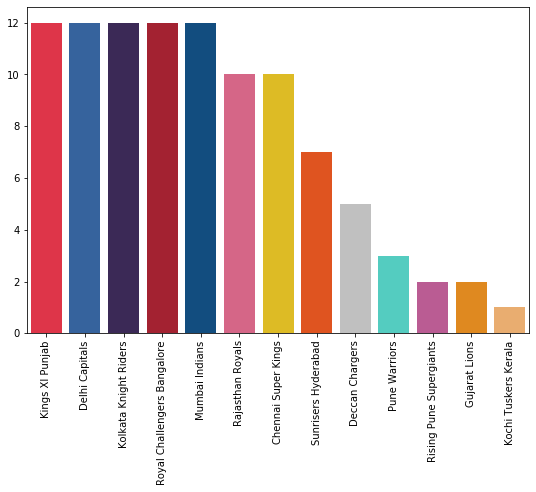

In [13]:
plt.figure(figsize=(9,6))
sns.barplot(x=list(td_sorted.keys()),y=list(td_sorted.values()),palette=colour_teams)
plt.xticks(rotation=90)

CSK has only featured in 10 editions of IPL, unlike the 12 appearances of MI and KKR. This is due to the 2 season ban both CSK and Rajasthan Royals (RR) faced due to corruption charges. Meanwhile, Sunrisers Hydrabad have only appeared in 7 seasons of the IPL. This may explain only having 1 season trophy, despite their high win percentage. The results may have been totally different if CSK had participated in the 2016 and 2017 editions. Given the facts, would you consider MI or CSK the most successful team in IPL history? Debatable!

Also of note, in this dataset we have considered the two teams to represent Hydrabad (Sunrisers and Deccan Chargers) as seperate teams. If we instead considered them as the same team, the statistics may tell a different story.

We move on now to our next dataset.

In [14]:
df_deliveries = pd.read_csv('ipl\deliveries.csv')
df_deliveries.head(3)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN


Let's find the highest first innings totals ever achieved in IPL history

In [15]:
df_deliveries.groupby(['match_id','inning']).agg('sum')['total_runs'].sort_values(ascending=False).head(5)

match_id  inning
411       1         263
7937      1         250
620       1         248
206       1         246
11338     1         241
Name: total_runs, dtype: int64

In [16]:
df_matches[df_matches['id']==411]

id,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
411,411,IPL-2013,Bangalore,2013-04-23,Royal Challengers Bangalore,Pune Warriors,Pune Warriors,field,normal,0,Royal Challengers Bangalore,130,0,CH Gayle,M Chinnaswamy Stadium


The highest first innings total ever was by RCB in 2013, courtesy an outrageous 175 from the Universe Boss himself, Chris Gayle!

Next we look at the most expensive overs:

In [17]:
df_deliveries.groupby(['match_id','inning','over']).agg('sum')['total_runs'].sort_values(ascending=False).head(5)

match_id  inning  over
283       2       3       37
208       1       13      33
516       2       6       33
329       2       13      31
11151     1       20      31
Name: total_runs, dtype: int64

In [18]:
df_deliveries[(df_deliveries['match_id']==283)&(df_deliveries['inning']==2)&(df_deliveries['over']==3)].loc[:,'over':'total_runs']

,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
67013,3,1,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,6,0,6
67014,3,2,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,1,0,6,1,7
67015,3,3,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,4,0,4
67016,3,4,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,4,0,4
67017,3,5,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,6,0,6
67018,3,6,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,6,0,6
67019,3,7,CH Gayle,TM Dilshan,P Parameswaran,0,0,0,0,0,0,4,0,4


In [19]:
df_matches[df_matches['id']==283]

id,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue
283,283,IPL-2011,Bangalore,2011-05-08,Kochi Tuskers Kerala,Royal Challengers Bangalore,Kochi Tuskers Kerala,bat,normal,0,Royal Challengers Bangalore,0,9,CH Gayle,M Chinnaswamy Stadium


T20 legend Chris Gayle makes another appearance, responsible for the most runs scored off a single over. Parameswaran went for 37 runs off a single over, including 7 runs off the second delivery (a no ball that went for 6). RCB went on to win by 9 wickets, on the back of another man of the match performance from Gayle.

We have investigated high scores and expensive overs, but what about situations in which the bowlers have shined? We next will find the maximum number of consecutive dot balls bowled in an IPL innings:

In [20]:
runs_from_ball = list(df_deliveries.loc[0:,'total_runs'])
        
cons_zero = []               #Calculate maximum number of consecutive dot balls
        
if runs_from_ball[0]==0:    
    cons_zero.append(1)
else:
    cons_zero.append(0)
  
for idx, val in enumerate(runs_from_ball[1:]):            
    if df_deliveries.loc[idx,'over']==1 and df_deliveries.loc[idx,'ball']==1:     #Restart at the change of each innings
        if runs_from_ball[idx]==0:
            cons_zero.append(1)
        else:
            cons_zero.append(0)
    else:
        if val==0:
            cons_zero.append(cons_zero[idx]+1)
        else:
             cons_zero.append(0)       

max_zero = [max(cons_zero),cons_zero.index(max(cons_zero))]

In [21]:
df_deliveries.iloc[(max_zero[1]-max_zero[0]):max_zero[1]+2,[4,5,6,7,8,15]]

,over,ball,batsman,non_striker,bowler,batsman_runs
56443,8,1,R McLaren,AM Nayar,WD Parnell,4
56444,8,2,R McLaren,AM Nayar,WD Parnell,0
56445,8,3,R McLaren,AM Nayar,WD Parnell,0
56446,8,4,R McLaren,AM Nayar,WD Parnell,0
56447,8,5,R McLaren,AM Nayar,WD Parnell,0
56448,8,6,R McLaren,AM Nayar,WD Parnell,0
56449,9,1,AM Nayar,R McLaren,JD Ryder,0
56450,9,2,AM Nayar,R McLaren,JD Ryder,0
56451,9,3,AM Nayar,R McLaren,JD Ryder,0
56452,9,4,PP Chawla,R McLaren,JD Ryder,0


In [22]:
df_deliveries.iloc[(max_zero[1]-max_zero[0]+1),[0,1,2,3]]

match_id                    239
inning                        1
batting_team    Kings XI Punjab
bowling_team      Pune Warriors
Name: 56444, dtype: object

Back in 2011, Pune Warriors managed to bowl 15 dot balls in a row to Kings XI Punjab. South Africans Wayne Parnell and Ryan McLaren were involved, with the former bowling 9 dot balls to the latter during this passage of play.

In T20 cricket, a strategy often employed by teams is to bat aggressively during the Powerplay (first 6 overs), more moderately during the middle stage of the game, before accelarating again towards the end of the innings (the death overs). Do the stats match the theory?

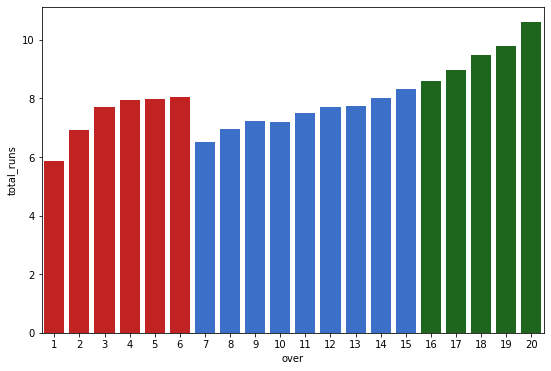

In [23]:
avg_per_over = df_deliveries.groupby('over').agg('mean')['total_runs']*6
colour_over = ['#DC0707']*6+['#2569DE']*9+['#127112']*5
plt.figure(figsize=(9,6))
sns.barplot(x=avg_per_over.index,y=avg_per_over,palette=colour_over)

Indeed it does. The graph suggests that batsmen look to play themselves in during the first over, before going hard during the rest of the Powerplay. Things slow down during the middle period of the game, gradually accelerating to a big finish at the end. But one would assume a more aggressive approach also comes with higher risk. Lets compare the runs per over to the wickets per over:

In [24]:
dis = df_deliveries['dismissal_kind'].astype(str)
df_deliveries['out'] = dis!='nan'

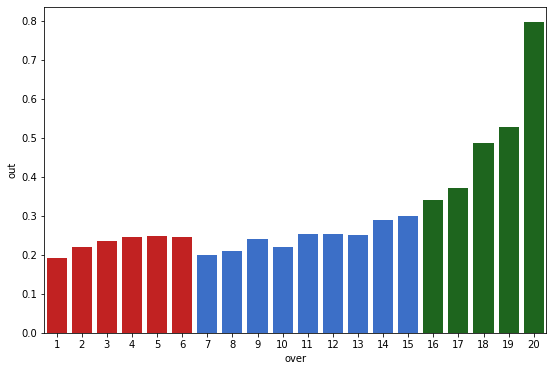

In [25]:
wickets_per_over = df_deliveries.groupby('over').agg('mean')['out']*6
plt.figure(figsize=(9,6))
sns.barplot(x=wickets_per_over.index,y=wickets_per_over,palette=colour_over)

As we can see, a high number of wickets fall during the death overs, a tradeoff for the higher runs per over achieved during this period. Surprisingly however, the average wickets per over during the Powerplay is relatively low, matching that of the middle overs. This suggests that an aggressive approach during the fielding restrictions of the Powerplay is highly beneficial, as you can achieve a high run rate without taking on additional risk.

Our final dataset contains some statistics on batsmen:

In [26]:
df_runs_strike = pd.read_csv('ipl\most_runs_average_strikerate.csv')
df_runs_strike.head(3)

,batsman,total_runs,out,numberofballs,average,strikerate
0,V Kohli,5426,152,4111,35.70,131.99
1,SK Raina,5386,160,3916,33.66,137.54
2,RG Sharma,4902,161,3742,30.45,131.00


In [27]:
df_rsfilt = df_runs_strike[df_runs_strike['total_runs']>500]
df_rsfilt.sort_values('average',ascending=False).head()

,batsman,total_runs,out,numberofballs,average,strikerate
97,HM Amla,577,13,407,44.38,141.77
8,AB de Villiers,4414,104,2902,42.44,152.10
30,JP Duminy,2031,49,1633,41.45,124.37
3,DA Warner,4717,114,3292,41.38,143.29
5,CH Gayle,4525,110,2972,41.14,152.25


In [28]:
df_rsfilt.sort_values('strikerate',ascending=False).head()

,batsman,total_runs,out,numberofballs,average,strikerate
49,AD Russell,1415,41,752,34.51,188.16
82,SP Narine,785,40,458,19.62,171.40
38,RR Pant,1767,49,1071,36.06,164.99
50,GJ Maxwell,1401,62,864,22.60,162.15
103,CH Morris,519,20,327,25.95,158.72


Above we find statistics on some of the most successful batsmen in IPL, firstly by considering average, and secondly by considering strike rate. An arbitrary cutoff of 500 runs was used, to exclude players with inflated numbers due to small sample size. 

Perhaps surprisingly, Hashim Amla leads the list as far as average is concerned, while also managing a healthy strike rate of 140+. While not known as a "big striker", this fact suggests a high quality player can succeed at any cricket format. It should be noted though that he only accrued a total of 577 runs, having not played as much T20 cricket as some of the other names.

Lets now apply a stronger filter of 1500 runs to see who are some of the more consistent performers in IPL:

In [29]:
df_rsfilt_strong = df_runs_strike[df_runs_strike['total_runs']>1500]
df_rsfilt_strong.sort_values('average',ascending=False).head()

,batsman,total_runs,out,numberofballs,average,strikerate
8,AB de Villiers,4414,104,2902,42.44,152.10
30,JP Duminy,2031,49,1633,41.45,124.37
3,DA Warner,4717,114,3292,41.38,143.29
5,CH Gayle,4525,110,2972,41.14,152.25
31,KL Rahul,1988,49,1428,40.57,139.22


In [30]:
df_rsfilt_strong.sort_values('strikerate',ascending=False).head()

,batsman,total_runs,out,numberofballs,average,strikerate
38,RR Pant,1767,49,1071,36.06,164.99
20,V Sehwag,2728,98,1746,27.84,156.24
5,CH Gayle,4525,110,2972,41.14,152.25
8,AB de Villiers,4414,104,2902,42.44,152.10
18,KA Pollard,2772,102,1879,27.18,147.53


We now notice far more household names in the above lists. AB de Villiers and Chris Gayle appear on both lists, a reflection of how dominant they have been in the IPL. But how about trying to rank batsmen, using a combination of all these statistics (innings batted, runs scored, average, strike rate). It is not really clear how to combine these is it? Perhaps a task better left to data science!